In [1]:
try:
  import utils

except:
  !pip install python-dotenv

In [2]:
import os

#os.chdir("/drive/MyDrive/data")

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
import torch

import random
import utils

plt.rcParams['figure.figsize'] = (17, 5)

c:\Users\alber\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
c:\Users\alber\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Impossibile trovare la procedura specificata'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [5]:
# Directory where mp3 are stored
AUDIO_DIR = 'Data/fma_small'

# Load metadata and features.
tracks = utils.load('Data/fma_metadata/tracks.csv')
#genres = utils.load('drive/MyDrive/data/fma_metadata/genres.csv')
#features = utils.load('drive/MyDrive/data/fma_metadata/features.csv')
#echonest = utils.load('drive/MyDrive/data/fma_metadata/echonest.csv')

#Assertions to ensure the consistency of indices in the loaded datasets.
#np.testing.assert_array_equal(features.index, tracks.index)
#assert echonest.index.isin(tracks.index).all()

tracks.shape #, genres.shape, features.shape, echonest.shape

(106574, 52)

In [6]:
#Select the desired subset among the entire dataset
sub = 'small'
raw_subset = tracks[tracks['set', 'subset'] <= sub]

# Audio

Audio signals are composed by a one-dimensional array that represents the amplitude of the audio signal over time, x in our definition. sr is instead the sampling rate providing the context for how these samples are distributed in time. The librosa.load function returns both the audio signal and its associated sampling rate.

In [7]:
#Function to extract audio signal from .mp3 file

def getAudio(idx):
  # Get the audio file path
  filename = utils.get_audio_path(AUDIO_DIR, idx)
  #print(f'File: {filename}')

  # Load the audio (sr = sampling rate, number of audio carries per second)
  x, sr = librosa.load(filename, sr=22050, mono=True)  #sr=None to consider original sampling rate

  return x, sr

x_ex = getAudio(2)

print(x_ex[1])
duration_seconds = x_ex[0].shape[-1] / x_ex[1]
print(f'Duration: {duration_seconds:.2f}s, {x_ex[0].size} samples')


# Play a segment of the audio
start, end = 7, 17
ipd.Audio(data=x_ex[0][start * x_ex[1] : end * x_ex[1]], rate=x_ex[1])

22050
Duration: 29.98s, 660984 samples


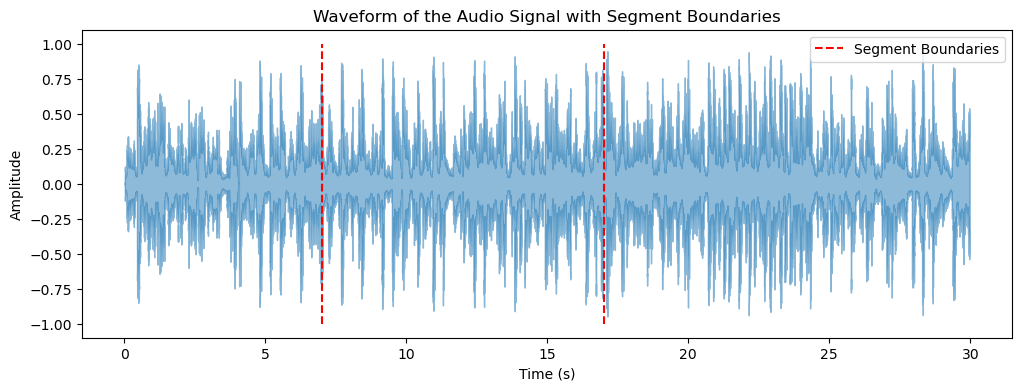

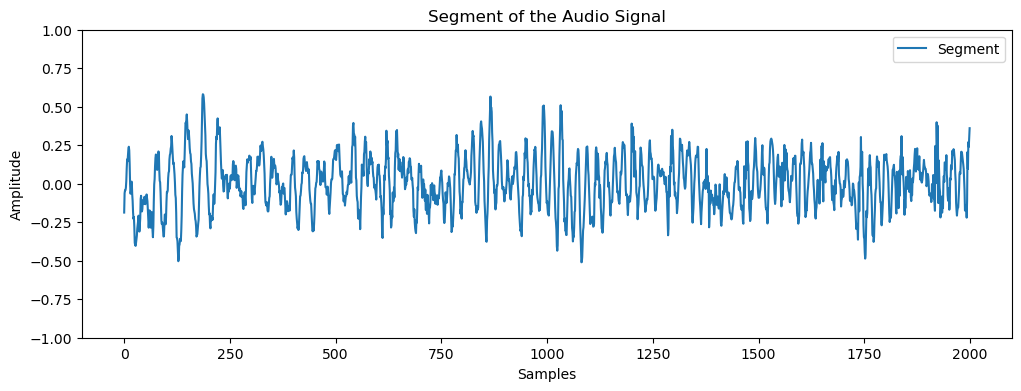

In [8]:
# Plot the entire waveform with vertical lines
plt.figure(figsize=(12, 4))
librosa.display.waveshow(x_ex[0], alpha=0.5)
plt.vlines([start, end], -1, 1, color='r', linestyle='--', label='Segment Boundaries')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of the Audio Signal with Segment Boundaries')
plt.legend()

plt.show()

# Create another plot for a segment of the audio signal
start_segment = len(x_ex[0]) // 2
plt.figure(figsize=(12, 4))
plt.plot(x_ex[0][start_segment:start_segment + 2000], label='Segment')  #Plot of 2000 samples starting from the midpoint onward
plt.ylim((-1, 1))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Segment of the Audio Signal')
plt.legend()

plt.show()

## Compute mel spectrogram

A mel spectrogram is a representation of the short-term power spectrum of a sound signal, where the frequencies are transformed into the mel scale. The mel scale is a perceptual scale of pitches that approximates the human ear's response to different frequencies. It is commonly used in audio processing and speech recognition because it aligns more closely with how humans perceive pitch differences.

In summary, a mel spectrogram is a way of representing the frequency content of an audio signal over time, with an emphasis on how humans perceive different frequencies. The mel scale helps better capture the relevant acoustic features for tasks like speech recognition and audio analysis.

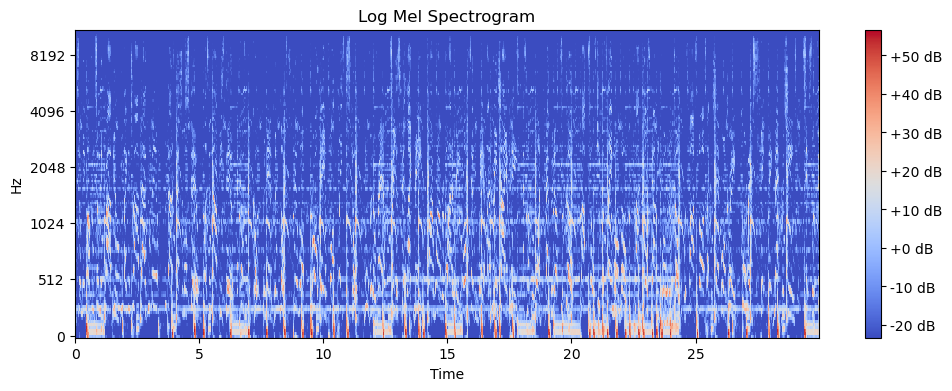

In [9]:
def comp_mel(x):

  # Compute the short-time Fourier transform (stft)
  stft = np.abs(librosa.stft(x[0], n_fft=1024, hop_length=512))  #n_fft to a power of two for optimizing the speed of the fast Fourier transform (FFT) algorithm.

  # Compute the mel spectrogram
  mel = librosa.feature.melspectrogram(sr=x[1], S=stft**2)
   
  return mel


# Convert the power spectrogram to decibels
mel_ex = comp_mel(x_ex)

log_mel_ex = librosa.amplitude_to_db(mel_ex)

# Plot the log mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_ex, sr=x_ex[1], hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.show()

In [10]:
log_mel_ex.shape

(128, 1291)

## Compute MFCCs

Mel-Frequency Cepstral Coefficients (MFCCs) are a widely used feature in speech and audio processing. They are coefficients that represent the short-term power spectrum of a sound signal, and they are derived from the Mel-frequency spectrum, which is a representation of the short-term power spectrum of a sound signal in the frequency domain.

MFCCs have proven to be effective in capturing the characteristics of audio signals for tasks such as speech recognition, speaker identification, and music genre classification. They compactly represent the spectral characteristics of a sound signal, emphasizing features that are important for human perception.

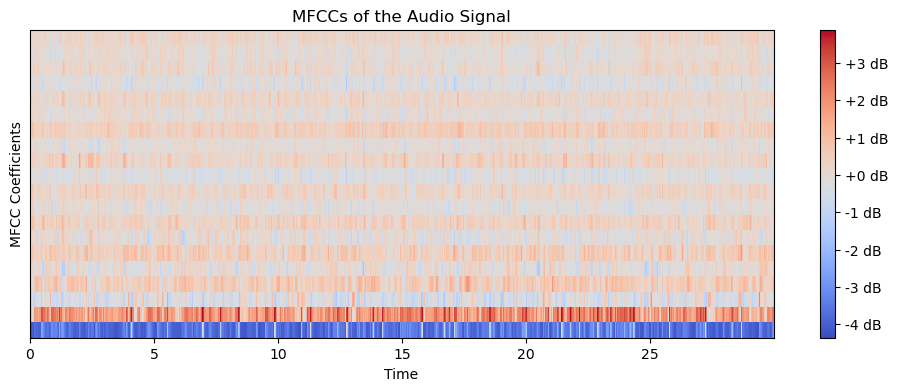

In [11]:
def comp_mfcc(mel):

  # Compute the MFCCs from the mel spectrogram
  mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)

  # Standardize the MFCCs
  mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)

  return mfcc

mfcc_ex = comp_mfcc(mel_ex)

# Display the MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc_ex, sr=x_ex[1], x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.title('MFCCs of the Audio Signal')
plt.show()

In [12]:
mfcc_ex.shape

(20, 1291)

### Creation of training, test and validation sets

In [13]:
#Part of subset dataset containing information about top_genres


#definition of labels and track_ids
labels = raw_subset['track']['genre_top']
labels = np.array(labels)

print(labels)
labels[:10]



['Hip-Hop' 'Hip-Hop' 'Pop' ... 'Pop' 'Pop' 'Hip-Hop']


array(['Hip-Hop', 'Hip-Hop', 'Pop', 'Folk', 'Folk', 'Experimental',
       'Rock', 'Folk', 'Folk', 'Folk'], dtype=object)

In [14]:
#get subsets indexes  (just to understand not actually useful)
train_meta = raw_subset[raw_subset['set', 'split'] == 'training']
val_meta = raw_subset[raw_subset['set', 'split'] == 'validation']
test_meta = raw_subset[raw_subset['set', 'split'] == 'test']
test_meta.shape

(800, 52)

In [39]:
#Function to convert labels into array of probabilities
def conv_label(label):
  le = LabelEncoder()
  y = le.fit_transform(label)
  y = to_categorical(y, 8)
  return y

#This function create a dataframe containing index and label for a subset, simplifying its structure and making it suitable 
#for the split into test, validation and validation sets
def create_subset(raw_sub):
  subset = pd.DataFrame(columns = ['index', 'genre_top', 'split'])
  subset['index'] = raw_sub['track'].index.tolist()
  subset['genre_top'] = raw_sub['track', 'genre_top'].tolist()
  subset['split'] = raw_sub['set', 'split'].tolist()
  return subset

subset = create_subset(raw_subset)
subset.shape

,index,genre_top,split
6,182,Rock,test
39,704,International,test
40,705,International,test
41,706,International,test
42,707,International,test
...,...,...,...
7992,154305,Hip-Hop,test
7993,154306,Hip-Hop,test
7994,154307,Hip-Hop,test
7995,154308,Hip-Hop,test


In [41]:
#Here we define functions for the creation of useful datasets for CNNs learning

#Function for the creation of 1d audio signal dataset
def splitAudio(subset, data_type):
    # Creare un array vuoto
    a = np.array([0,0])
    split = subset[subset['split'] == data_type]
    labels =  conv_label(subset['genre_top'])   
    for i in split.index: 
        try:         
            audio = np.array(getAudio(split['index'][i])[0])
            y = labels[i]
            new_row = np.array([audio, y], dtype=object)
            a = np.vstack([a, new_row])
        except:
            print('problems with song: ', split['index'][i])
    return a[1:]

In [42]:
#Creation of Audio datasets arrays

test = splitAudio(subset, 'test')

In [49]:
training = splitAudio(subset, 'training')
validation = splitAudio(subset, 'validation')

problems with song:  98565
problems with song:  98567
problems with song:  98569
problems with song:  99134
problems with song:  108925
problems with song:  133297


In [55]:
#Visualize dataset array
training[0,1].shape

array([0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [56]:
#Functions for the creation of .npy files for heavy arrays (split arrays in multiple files and then reconstrict it)

def saveheavy(a, name, n):  #functions to save havy arrays in multiple files
    l= len(a)
    if(n>1):
        for i in range(n-1):
            a_i = a[int((l/n)*i):int((l/n)*(i+1))]
            np.save(f'{name}_{i+1}.npy', a_i)
    a_i = a[int((l/n)*(n-1)):l]
    np.save(f'{name}_{n}.npy', a_i)
    
def readheavy(name, n, Dir):
    a = np.array([0,0])
    for i in range(n):
        new_a = np.load(f'Data/{Dir}/{name}_{i+1}.npy', allow_pickle = True)
        a = np.vstack([a, new_a])
    return a[1:]  

In [57]:
saveheavy(test, 'test', 2)
saveheavy(validation, 'validation', 2)
saveheavy(training, 'training', 16)

In [ ]:
#s1